## 足球比赛数据与比赛结果的相关性分析

足球比赛的各项数据统计可以在多大程度上对应比赛结果？哪种足球数据统计与比赛结果最为相关？比如，我们是否应该关注控球率？本文利用机器学习中的监督学习来回答这些问题。

需要注意的是，本文所采用的方法为描述性建模，其并非预测性建模，因此无法对比赛结果进行赛前预测；这一方法也不是解释性建模，因此无法为分析结果提供因果解释。关于这三种建模方法的区别，参见Shmueli (2010)[$^{[1]}$](https://projecteuclid.org/euclid.ss/1294167961)。

#### 相关文献
* Collet (2013)[$^{[2]}$](https://www.tandfonline.com/doi/abs/10.1080/02640414.2012.727455)指出，一旦将球队水平和主场优势考虑在内，控球时间和传球次数对比赛结果的预测能力会很差。
* Matthew. (2015)[$^{[3]}$](https://dspace.mit.edu/handle/1721.1/100607)指出，传中次数与比赛结果的相关性很强，且相关系数为负数。预测准确率最高的模型是带L2正则项的逻辑回归分类器，准确率达到了84%。值得注意的是，这一准确率是将比赛结果为平局的比赛忽略后得到的。若将平局的比赛考虑在内，并假设平局占所有比赛的25%，且模型对平局比赛的预测准确率为0，那么这一准确率等价于当平局被考虑在内时的63%。

#### 数据来源
* Kaggle欧洲足球数据库[$^{[4]}$](https://www.kaggle.com/hugomathien/soccer)：[数据准备指南](https://github.com/xzl524/football_data_analysis/tree/master/data_source/kaggle)
* Squawka足球数据网站[$^{[5]}$](http://www.squawka.com)：[数据准备指南](https://github.com/xzl524/football_data_analysis/tree/master/data_source/squawka)

#### 主要结论

* 主要模型结果总结如下：

|数据|                   模型                               |   预测准确率  | 对数损失|
|:----:| :------------------------------------------------:| :-----------:|:----:|
|Kaggle| 基准结果：随机猜测                                  | 33.5%        |/|
|Kaggle| 基准结果：只猜主队赢                                | 45.9%        |/|
|Kaggle| 逻辑回归                                           | 56.6%        |0.9240|
|Kaggle| 线性判别分析                                       | 56.6%        |0.9195|
|Kaggle| 泊松回归                                           | 56.0%        |0.9329|
|Kaggle| XGBoost                                           | 56.7%        |0.9278|
|Kaggle| 随机森林                                           | 56.4%        |0.9458|
|Kaggle| 神经网络                                           | 56.2%        |0.9216|
|Squawka| 逻辑回归                                          | 60.5%        |0.8725|
|Squawka| 线性判别分析                                      | 60.9%        |0.8669|
|Squawka| 泊松回归                                          | 59.8%        |0.8875|
|Squawka| XGBoost                                          | 59.3%        |0.9264|
|Squawka| 随机森林                                          | 60.2%        |0.8767|
|Squawka| 神经网络                                          | 60.2%        |0.8548|

* 使用Kaggle数据的模型预测准确率在56-57%左右，而使用Squawka数据的模型预测准确率更高，为59-61%。这主要源于Squawka数据中与比赛结果相关的数据类型更多，同时更大的数据量降低了模型过拟合的风险。
* 总体来说，影响比赛结果的数据排前三位的分别是：射门，传中，守门，其中传中数与进球数之间的相关系数为负数。这意味着，传中越多，进球越少。
* 传中数与进球数相关，并不意味着传中与进球就有着直接的因果关系。监督学习无法说明传中是如何影响进球的。这里提一种假设：传中数其实可以看做是反映对手防守质量的一个指标。传中数越多，表示对方的防守越好，本方很难直接打入对方腹地，只能通过传中这样的手段来进攻。
* 不管怎么样，鉴于传中次数对比赛结果的影响，这一数据需要在比赛转播和赛后数据统计中有所体现。

#### 详细内容
1. [基准结果](#baseline)
2. [Kaggle数据的相关性分析](#kaggle)
3. [Squakwa数据的相关性分析](#squawka)

In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from footballmodels import PoissonRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras

sns.set_style('white')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #图中显示中文

In [2]:
def plot_history(history, kind='acc'):
    plt.figure()
    plt.xlabel('遍历次数')
    if kind == 'acc':
        plt.ylabel('准确率')
        plt.plot(history.epoch, np.array(history.history['acc']),
                 label='训练集')
        plt.plot(history.epoch, np.array(history.history['val_acc']),
                 label = '验证集')
        plt.legend()
    elif kind == 'loss':
        plt.ylabel('对数损失')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='训练集')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = '验证集')
        plt.legend()

#### <a id='baseline'></a>1. 基准结果

In [3]:
# 导入包含比赛数据统计信息的比赛数据
data_folder = os.path.join(os.path.pardir, 'data_source', 'kaggle')
match = pd.read_csv(os.path.join(data_folder, 'match.csv'))

# 合成净胜球数
goal_diff = match['home_team_goal'] - match['away_team_goal']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
y = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

print('预测准确率\n')
# 随机猜测
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('随机猜测：  {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# 只猜主队赢
y_pred = np.zeros(len(y))
print('只猜主队赢：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

# 只猜平局
y_pred = np.ones(len(y))
print('只猜平局：  {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# 只猜客队赢
y_pred = 2*np.ones(len(y))
print('只猜客队赢：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

预测准确率

随机猜测：  33.5%
只猜主队赢：45.9%
只猜平局：  25.4%
只猜客队赢：28.7%


由理论计算可知，随机猜测的准确率为33.3%。

这是因为：假设胜/平/负三种结果出现的概率分别为$p_{w}$，$p_{d}$，和$p_{l}$，那么随机猜测时猜对胜这种结果的概率为$\frac{p_{w}}{3}$，猜对打平这种结果的概率为$\frac{p_{d}}{3}$，猜对负这种结果的概率为$\frac{p_{l}}{3}$。因此，随机猜测的准确率为：

$$\frac{p_w}{3}+\frac{p_d}{3}+\frac{p_l}{3}=\frac{p_w+p_d+p_l}{3}=\frac{1}{3}=33.3\% $$.

数据与理论计算结果非常接近。

#### <a id='kaggle'></a>2. Kaggle数据的相关性分析
Kaggle欧洲足球数据库中包含的比赛相关数据有：犯规、红黄牌、传中、角球、控球率和射门。另外，主客队的数据都会使用。

In [4]:
# 导入包含比赛数据统计信息的比赛数据
data_folder = os.path.join(os.path.pardir, 'data_source', 'kaggle')
match = pd.read_csv(os.path.join(data_folder, 'match.csv'))

# 射门相关的数据包括：射正（非进球）数、射偏数和进球数
shot_events = ['shoton', 'shotoff', 'goal']

# 选择主客队射门相关的信息
home_team_feature = ['home_team_{}'.format(i) for i in shot_events]
away_team_feature = ['away_team_{}'.format(i) for i in shot_events]

# 移除缺失数据
for col in home_team_feature + away_team_feature:
    match = match[match[col].notnull()]

# 合成射门数
match['home_team_shot'] = match['home_team_shoton'] + match['home_team_shotoff'] + match['home_team_goal']
match['away_team_shot'] = match['away_team_shoton'] + match['away_team_shotoff'] + match['away_team_goal']

# 合成净胜球数
goal_diff = match['home_team_goal'] - match['away_team_goal']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
match['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

# 选择比赛相关信息
events = ['foulcommit', 'card', 'cross', 'corner', 'possession', 'shot']
event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# 确认使用的信息
feature_list = event_features

# 生成建模数据
# 移除缺失值
match_sel = match
for col in feature_list:
    match_sel = match_sel[match_sel[col].notnull()]
    
# 训练集/测试集划分
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

gdtrain = hgoaltrain-agoaltrain
gdtest = hgoaltest-agoaltest

# 输入数据正则化
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

print('总数据量：                    {}'.format(match_sel.shape[0]))
print('训练数据量（包括交叉验证数据）：{}'.format(train_df.shape[0]))
print('测试数据量：                  {}'.format(test_df.shape[0]))

总数据量：                    8124
训练数据量（包括交叉验证数据）：7124
测试数据量：                  1000


2.1 逻辑回归

最优的C为：100000.0
对数损失值（训练数据）：  0.9327
对数损失值(交叉验证数据)：0.9363


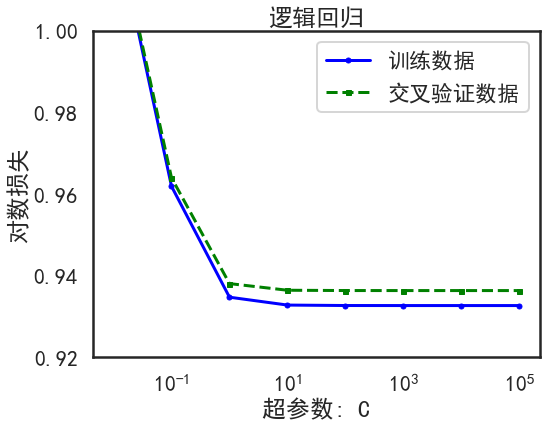

In [5]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# 使用交叉验证和对数损失来确定超参数
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.xlabel('超参数：{}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.92, 1)

print('最优的{}为：{}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('对数损失值（训练数据）：  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('对数损失值(交叉验证数据)：{:.4f}'.format(-1*np.max(test_mean)))

In [6]:
best_clf = LogisticRegression(C=100000, multi_class='auto', solver='liblinear')

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('逻辑回归模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

逻辑回归模型评估
对数损失：  0.9240
预测准确率：56.6%


2.2 线性判别分析

In [7]:
best_clf = LinearDiscriminantAnalysis()

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('线性判别分析模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

线性判别分析模型评估
对数损失：  0.9195
预测准确率：56.6%


2.3 泊松回归

利用泊松回归建模分两步：
1. 使用泊松回归模型，由比赛相关信息来估计主队和客队的进球数期望值；
2. 比较主客队的进球数期望值，利用泊松分布计算比赛胜平负出现的概率。

In [8]:
best_clf = PoissonRegression()

best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)

#### 模型评估
print('泊松回归模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

泊松回归模型评估
对数损失：  0.9329
预测准确率：56.0%


泊松回归中信息关联性分析

In [9]:
feature_dic = {'home_team_foulcommit': '主队犯规数',
               'home_team_card': '主队红黄牌数',
               'home_team_cross': '主队传中数',
               'home_team_corner': '主队角球数',
               'home_team_possession': '主队控球率',
               'home_team_shot': '主队射门数',
               'away_team_foulcommit': '客队犯规数',
               'away_team_card': '客队红黄牌数',
               'away_team_cross': '客队传中数',
               'away_team_corner': '客队角球数',
               'away_team_possession': '客队控球率',
               'away_team_shot': '客队射门数'}

# 显示中文特征值
feature_list_cn = [feature_dic[key] for key in feature_list]

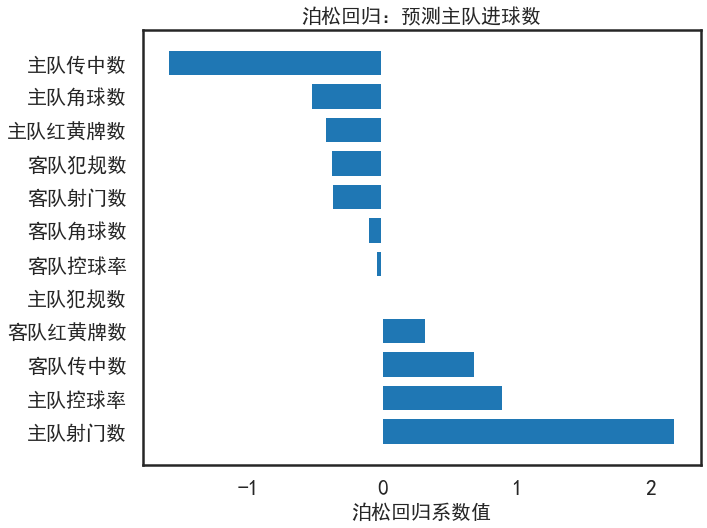

In [10]:
encoded_home_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测主队进球数', fontsize=20)
plt.show()

可以看到，与主队进球数最相关的是主队射门数，射门越多，进球越多。其次是主队传中数，但是注意，两者的关系是负的，传中越多，进球越少。主队控球率与进球数有一定的关联，但与前两者相比并不明显。

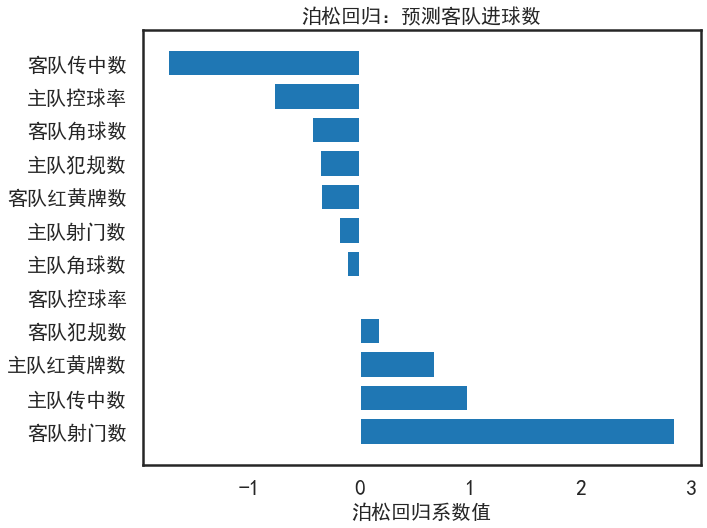

In [11]:
encoded_away_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测客队进球数', fontsize=20)
plt.show()

另一方面，与客队进球数最相关的数据是客队射门数，射门越多，进球越多。其次是客队传中数，传中数越多，进球越少。而客队控球率与进球数的关联就微乎其微了。

上面的结果显示，球队的传中数越多，进球数就越少。这一结论与Matthew. (2015)[$^{[3]}$](https://dspace.mit.edu/handle/1721.1/100607)相同。那么这是否意味着，要想多进球，只要尽量不传中就可以了呢？

事实上，并没有这样的结论。这是非常需要注意的一点，也是很容易犯的错误。监督学习之类的数据分析工具只能对不同变量之间的相关性进行分析，而无法验证其中的因果关系。传中数与进球数相关，并不意味着传中与进球就有着直接的因果关系。

监督学习无法说明传中是如何影响进球的。这里提一种假设：传中数其实可以看做是反映对手防守质量的一个指标。传中数越多，表示对方的防守越好，本方很难直接打入对方腹地，只能通过传中这样的手段来进攻。

2.4 XGBoost回归器+逻辑回归分类器

In [25]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.07
param_reg['subsample'] = 0.4
param_reg['colsample_bytree'] = 0.9
param_reg['max_depth'] = 2
param_reg['num_parallel_tree'] = 4
param_reg['min_child_weight'] = 5

parameter_dic = {'eta':np.arange(0.01, 0.1, 0.01)}
param_tune = list(parameter_dic.keys())[0]
param_len = len(parameter_dic[param_tune])

cross_validation_fold = 10

xgb_cv = []
kf = KFold(n_splits=cross_validation_fold, shuffle=True, random_state=42)

train_mean = []
val_mean = []

reg_progress = {}
clf_progress = {}

reg_num_boost_round_mean = []
clf_num_boost_round_mean = []

for i in range(param_len):
    param_reg[param_tune] = parameter_dic[param_tune][i]
    
    train_scores = []
    val_scores = []
    
    reg_num_boost_round = []
    clf_num_boost_round = []
    
    for train, val in kf.split(Xtrain, gdtrain):
        dtrain = xgb.DMatrix(Xtrain[train], label = gdtrain[train])
        dval = xgb.DMatrix(Xtrain[val], label = gdtrain[val])
        reg = xgb.train(params=param_reg, dtrain=dtrain,
                        num_boost_round=3000,
                        early_stopping_rounds=25, evals=[(dval,'validation')],
                        evals_result=reg_progress,
                        verbose_eval=False)
        reg_num_boost_round.append(len(reg_progress['validation']['rmse']))
        Ztrain = reg.predict(dtrain).reshape(-1, 1)
        Zval = reg.predict(dval).reshape(-1, 1)
        ltrain = xgb.DMatrix(Ztrain, label=ytrain[train])
        lval = xgb.DMatrix(Zval, label = ytrain[val])
        
        clf = LogisticRegression(solver='liblinear', C=10000) # minimizing regularization by setting C to a very large number
        clf.fit(Ztrain, ytrain[train])
        train_scores.append(log_loss(ytrain[train], clf.predict_proba(Ztrain)))
        val_scores.append(log_loss(ytrain[val], clf.predict_proba(Zval)))

    train_mean.append(np.mean(np.array(train_scores)))
    val_mean.append(np.mean(np.array(val_scores)))
    
    reg_num_boost_round_mean.append(np.mean(np.array(reg_num_boost_round)))

print(reg_num_boost_round_mean)

[1500.6, 819.9, 533.2, 415.2, 360.9, 306.0, 262.9, 219.8, 205.3]


最优的eta为：0.06999999999999999
对数损失值（交叉验证数据）：0.9431


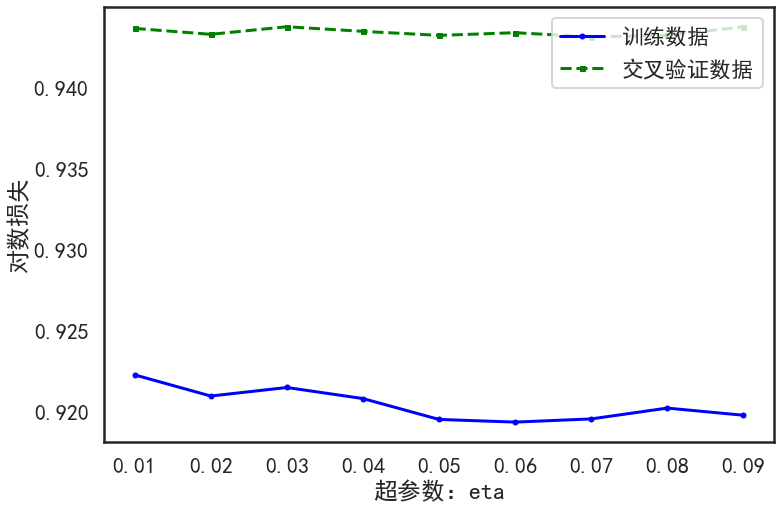

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(parameter_dic[param_tune], np.array(train_mean),
         color='blue', marker='o', markersize=5, label='训练数据')
plt.plot(parameter_dic[param_tune], np.array(val_mean),
         color='green', linestyle='--', marker='s', markersize=5, label='交叉验证数据')
plt.xlabel('超参数：{}'.format(param_tune))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
print('最优的{}为：{}'.format(param_tune, parameter_dic[param_tune][np.argmin(val_mean)]))
print('对数损失值（交叉验证数据）：{:.4f}'.format(np.min(val_mean)))

In [27]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.07
param_reg['subsample'] = 0.4
param_reg['colsample_bytree'] = 0.9
param_reg['max_depth'] = 2
param_reg['num_parallel_tree'] = 4
param_reg['min_child_weight'] = 5

dtrain = xgb.DMatrix(Xtrain, label = gdtrain)
reg = xgb.train(params=param_reg, dtrain=dtrain,
                num_boost_round=int(263),
                verbose_eval=False)
        
Ztrain = reg.predict(dtrain).reshape(-1, 1)
clf = LogisticRegression(solver='liblinear', C=10000)
clf.fit(Ztrain, ytrain)

dtest = xgb.DMatrix(Xtest, label = gdtest)
Ztest = reg.predict(dtest).reshape(-1,1)
ytest_prob = clf.predict_proba(Ztest)

print('XGBoost模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

XGBoost模型评估
对数损失：0.9278
预测准确率：56.7%


2.5 随机森林

最优的n_estimators为：170
对数损失值（训练数据）：  0.2417
对数损失值(交叉验证数据)：0.9589


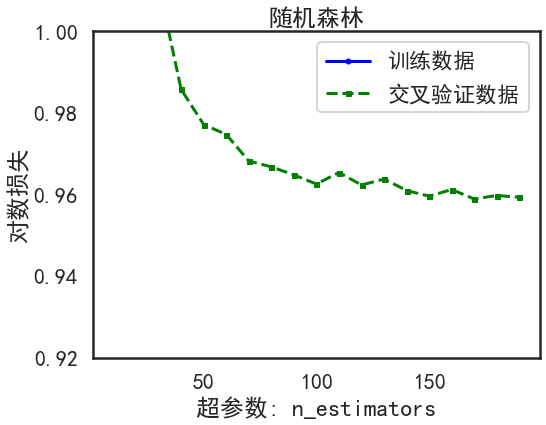

In [29]:
clf = RandomForestClassifier(max_features=3, n_estimators=160)
parameter_dic= {'n_estimators':range(10, 200, 10)}

# 使用交叉验证和对数损失来确定超参数
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.xlabel('超参数: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.92, 1)

print('最优的{}为：{}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('对数损失值（训练数据）：  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('对数损失值(交叉验证数据)：{:.4f}'.format(-1*np.max(test_mean)))

In [30]:
best_clf = RandomForestClassifier(max_features=3, n_estimators=170)

np.random.seed(42)
best_clf.fit(Xtrain, ytrain)
ytest_prob = best_clf.predict_proba(Xtest)

#### 模型评估
print('随机森林模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

随机森林模型评估
对数损失：  0.9458
预测准确率：56.4%


特征重要性分析

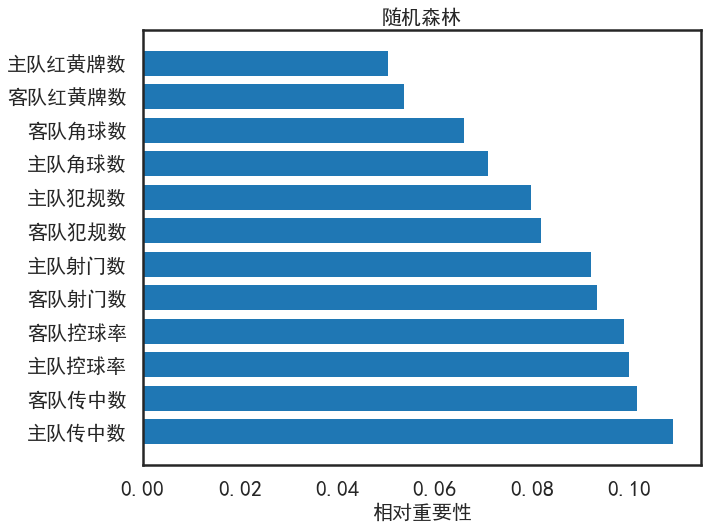

In [31]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('随机森林', fontsize=20)
plt.show()

在随机森林中，传中数的影响排在了第一，其次是控球率，然后才是射门数。

2.6 神经网络

In [32]:
# 训练集/验证集划分
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.7),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

当前模型训练集的准确率为55.86%
当前模型训练集的对数损失为0.940
当前模型验证集的准确率56.30%
当前模型验证集的对数损失为0.934


(0.9, 1)

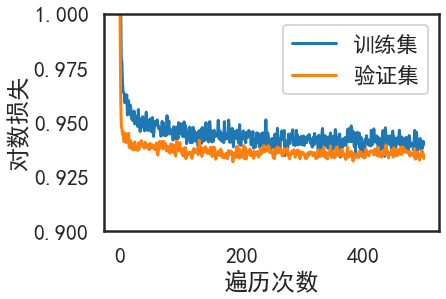

In [78]:
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=500,
                    validation_data=(val_x, val_y), verbose=0)

print('当前模型训练集的准确率为{:.2f}%'.format(history.history['acc'][-1]*100))
print('当前模型训练集的对数损失为{:.3f}'.format(history.history['loss'][-1]))

print('当前模型验证集的准确率{:.2f}%'.format(history.history['val_acc'][-1]*100))
print('当前模型验证集的对数损失为{:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.9, 1);

In [33]:
# 拟合训练数据
model.fit(Xtrain_norm, ytrain, epochs=500, verbose=0)

# 输出比赛结果概率估计
ytest_prob = model.predict_proba(Xtest_norm)

#### 模型评估
print('神经网络模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

神经网络模型评估
对数损失：  0.9216
预测准确率：56.2%


#### <a id='squawka'></a>3. Squawka数据的相关性分析

在Squawka数据中，使用的比赛相关数据有：射门、犯规、传中、角球、解围、红黄牌、传球、一对一次、铲球、越位、守门员解围、断球、头球争顶、守门、阻挡、出界。另外，主客队的数据都会使用。

注意：没有使用定位球数据，因为在此数据集中，只有产生进球的定位球和点球才会被记录在定位球数据中，所以其中含有进球信息。

In [37]:
# 导入包含比赛数据统计信息的比赛数据
data_dir = os.path.join(os.path.pardir, 'data_source', 'squawka', 'out', 'matchstats.csv')
match = pd.read_csv(data_dir, encoding='utf-8', low_memory=False)

# 合成净胜球数
goal_diff = match['home_team_goals'] - match['away_team_goals']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
match['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

events = ['takeons', 'tackles', 'goal_keeping', 'goals_attempts', 'fouls',
          'crosses', 'corners', 'cards', 'all_passes', 'offside',
          'keepersweeper', 'interceptions', 'headed_duals', 'clearances',
          'blocked_events', 'balls_out']

event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# Select features
feature_list = event_features

# Remove null-data matches
match_sel = match
for col in feature_list:
    match_sel = match_sel[match_sel[col].notnull()]

match_sel = match_sel[feature_list+['result','home_team_goals','away_team_goals']]

# 训练集/测试集划分
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goals'].values
hgoaltest = test_df['home_team_goals'].values

agoaltrain = train_df['away_team_goals'].values
agoaltest = test_df['away_team_goals'].values

gdtrain = hgoaltrain-agoaltrain
gdtest = hgoaltest-agoaltest

# 输入数据正则化
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

print('总数据量：                          {}'.format(match_sel.shape[0]))
print('训练数据量（包括交叉验证数据）：      {}'.format(Xtrain_norm.shape[0]))
print('测试数据量：                        {}'.format(Xtest_norm.shape[0]))

总数据量：                          11689
训练数据量（包括交叉验证数据）：      10689
测试数据量：                        1000


3.1 逻辑回归

最优的C为：100000.0
对数损失值（训练数据）：  0.8785
对数损失值(交叉验证数据)：0.8869


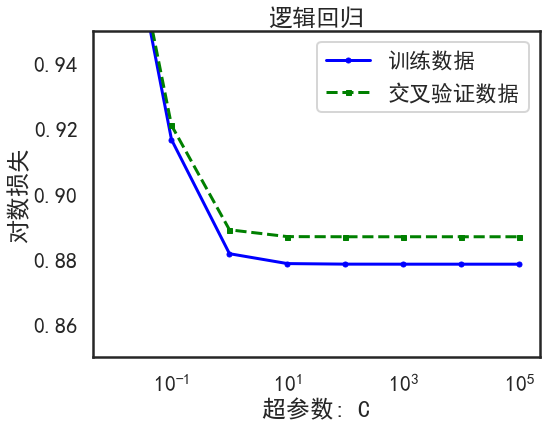

In [38]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# 使用交叉验证和对数损失来确定超参数
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.xlabel('超参数: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.85, 0.95)

print('最优的{}为：{}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('对数损失值（训练数据）：  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('对数损失值(交叉验证数据)：{:.4f}'.format(-1*np.max(test_mean)))

In [39]:
best_clf = LogisticRegression(C=100000, multi_class='auto', solver='liblinear')

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('逻辑回归模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

逻辑回归模型评估
对数损失：  0.8725
预测准确率：60.5%


3.2 线性判别分析

In [40]:
best_clf = LinearDiscriminantAnalysis()

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('线性判别分析模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

线性判别分析模型评估
对数损失：  0.8669
预测准确率：60.9%


3.3 泊松回归

In [41]:
best_clf = PoissonRegression()

best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)

#### 模型评估
print('泊松回归模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

泊松回归模型评估
对数损失：  0.8875
预测准确率：59.8%


In [42]:
feature_dic = {'home_team_takeons': '主队一对一次数',
               'home_team_tackles': '主队铲球数',
               'home_team_all_passes': '主队传球数',
               'home_team_offside': '主队越位次数',
               'home_team_keepersweeper': '主队守门员解围数',
               'home_team_interceptions': '主队断球数',
               'home_team_headed_duals': '主队头球争顶数',
               'home_team_goal_keeping': '主队守门员守门次数',
               'home_team_goals_attempts': '主队射门数',
               'home_team_fouls': '主队犯规数',
               'home_team_crosses': '主队传中数',
               'home_team_corners': '主队角球数',
               'home_team_clearances': '主队解围数',
               'home_team_cards': '主队红黄牌数',
               'home_team_blocked_events': '主队阻挡次数',
               'home_team_balls_out': '主队出界次数',
               'away_team_takeons': '客队一对一次数',
               'away_team_tackles': '客队铲球数',
               'away_team_all_passes': '客队传球数',
               'away_team_offside': '客队越位次数',
               'away_team_keepersweeper': '客队守门员解围数',
               'away_team_interceptions': '客队断球数',
               'away_team_headed_duals': '客队头球争顶数',
               'away_team_goal_keeping': '客队守门员守门次数',
               'away_team_goals_attempts': '客队射门数',
               'away_team_fouls': '客队犯规数',
               'away_team_crosses': '客队传中数',
               'away_team_corners': '客队角球数',
               'away_team_clearances': '客队解围数',
               'away_team_cards': '客队红黄牌数',
               'away_team_blocked_events': '客队阻挡次数',
               'away_team_balls_out': '客队出界次数'}

# 显示中文特征值
feature_list_cn = [feature_dic[key] for key in feature_list]

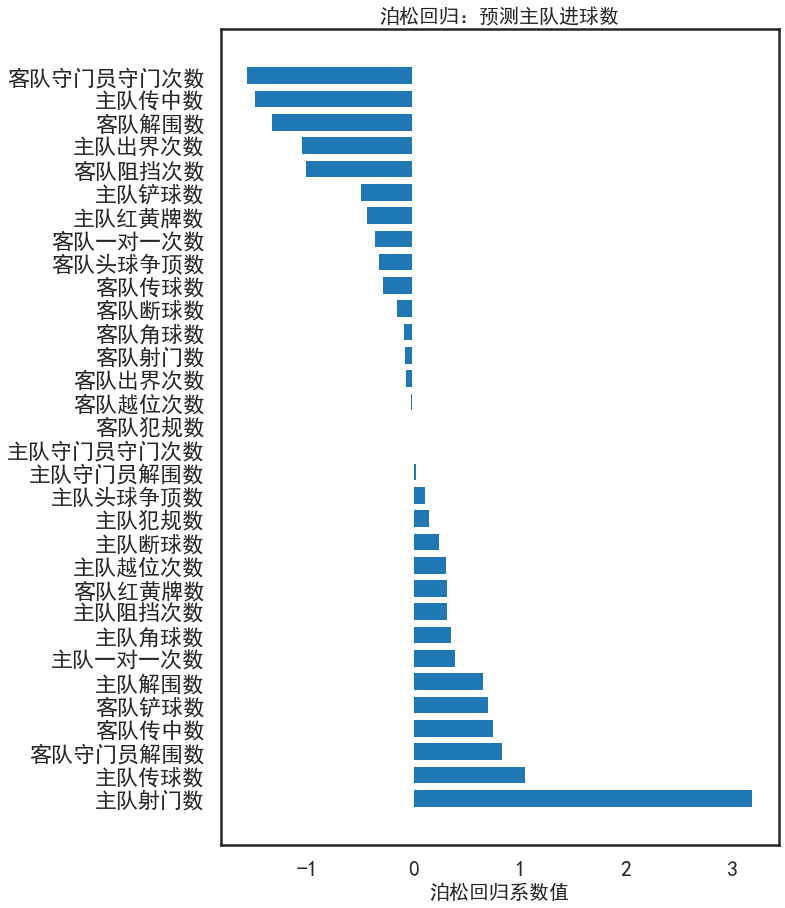

In [43]:
encoded_home_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测主队进球数', fontsize=20)
#plt.xlim(-1,1)
plt.show()

可以看到，与主队进球数最相关的是主队射门数，射门越多，进球越多。其次是客队守门员守门次数。排在第三的是主队传中数，与Kaggle数据的结果相同，传中数与进球数的相关系数为负数，传中越多，进球越少。

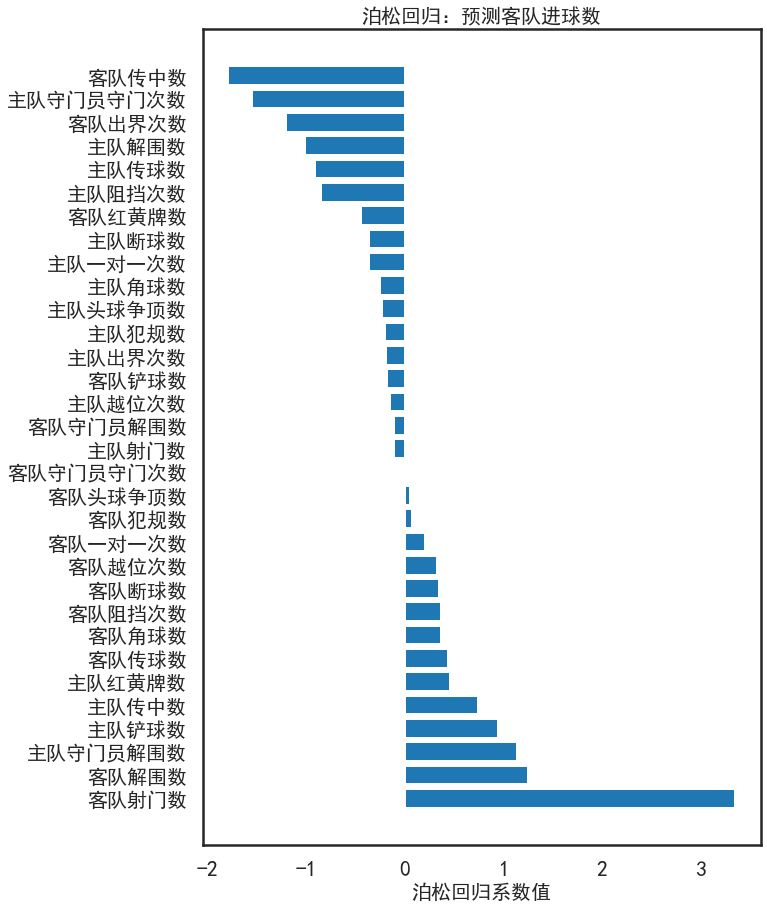

In [44]:
encoded_away_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测客队进球数', fontsize=20)
#plt.xlim(-1,1)
plt.show()

另一方面，与客队进球数最相关的数据是客队射门数，射门越多，进球越多。其次是客队传中数，传中数越多，进球越少。

3.4 XGBoost回归器+逻辑回归分类器

In [57]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] = 'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.06
param_reg['subsample'] = 0.2
param_reg['colsample_bytree'] = 0.5
param_reg['max_depth'] = 3
param_reg['num_parallel_tree'] = 3
param_reg['min_child_weight'] = 5

parameter_dic = {'eta':np.arange(0.01, 0.1, 0.01)}
param_tune = list(parameter_dic.keys())[0]
param_len = len(parameter_dic[param_tune])

cross_validation_fold = 10

xgb_cv = []
kf = KFold(n_splits=cross_validation_fold, shuffle=True, random_state=42)

train_mean = []
val_mean = []

reg_progress = {}
clf_progress = {}

reg_num_boost_round_mean = []
clf_num_boost_round_mean = []

for i in range(param_len):
    param_reg[param_tune] = parameter_dic[param_tune][i]
    
    train_scores = []
    val_scores = []
    
    reg_num_boost_round = []
    clf_num_boost_round = []
    
    for train, val in kf.split(Xtrain, gdtrain):
        dtrain = xgb.DMatrix(Xtrain[train], label = gdtrain[train])
        dval = xgb.DMatrix(Xtrain[val], label = gdtrain[val])
        reg = xgb.train(params=param_reg, dtrain=dtrain,
                        num_boost_round=3000,
                        early_stopping_rounds=25, evals=[(dval,'validation')],
                        evals_result=reg_progress,
                        verbose_eval=False)
        reg_num_boost_round.append(len(reg_progress['validation']['rmse']))
        Ztrain = reg.predict(dtrain).reshape(-1, 1)
        Zval = reg.predict(dval).reshape(-1, 1)
        ltrain = xgb.DMatrix(Ztrain, label=ytrain[train])
        lval = xgb.DMatrix(Zval, label = ytrain[val])
        
        clf = LogisticRegression(solver='liblinear', C=10000) # minimizing regularization by setting C to a very large number
        clf.fit(Ztrain, ytrain[train])
        train_scores.append(log_loss(ytrain[train], clf.predict_proba(Ztrain)))
        val_scores.append(log_loss(ytrain[val], clf.predict_proba(Zval)))

    train_mean.append(np.mean(np.array(train_scores)))
    val_mean.append(np.mean(np.array(val_scores)))
    
    reg_num_boost_round_mean.append(np.mean(np.array(reg_num_boost_round)))

print(reg_num_boost_round_mean)

[1973.8, 1002.2, 713.8, 647.0, 470.3, 394.6, 350.7, 297.6, 268.5]


最优的eta为：0.060000000000000005
对数损失值（交叉验证数据）：0.8870


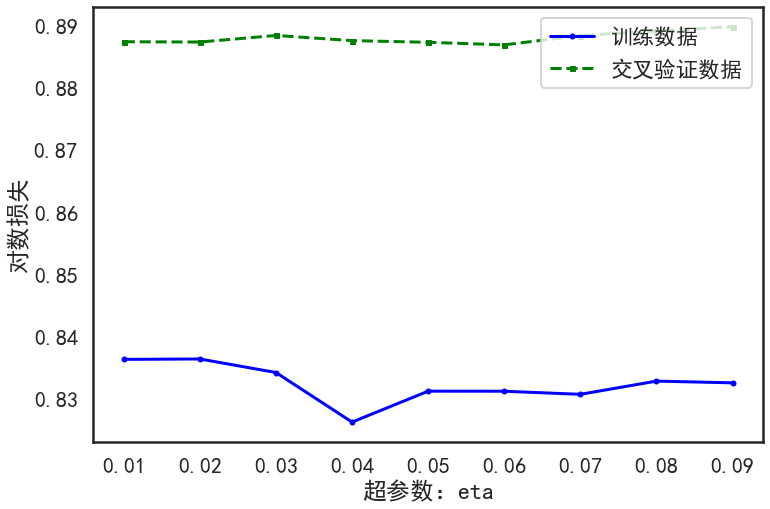

In [58]:
plt.figure(figsize=(12, 8))
plt.plot(parameter_dic[param_tune], np.array(train_mean),
         color='blue', marker='o', markersize=5, label='训练数据')
plt.plot(parameter_dic[param_tune], np.array(val_mean),
         color='green', linestyle='--', marker='s', markersize=5, label='交叉验证数据')
plt.xlabel('超参数：{}'.format(param_tune))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
print('最优的{}为：{}'.format(param_tune, parameter_dic[param_tune][np.argmin(val_mean)]))
print('对数损失值（交叉验证数据）：{:.4f}'.format(np.min(val_mean)))

In [61]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] = 'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.06
param_reg['subsample'] = 0.2
param_reg['colsample_bytree'] = 0.5
param_reg['max_depth'] = 3
param_reg['num_parallel_tree'] = 3
param_reg['min_child_weight'] = 5

dtrain = xgb.DMatrix(Xtrain, label = gdtrain)
reg = xgb.train(params=param_reg, dtrain=dtrain,
                num_boost_round=int(1974),
                verbose_eval=False)
        
Ztrain = reg.predict(dtrain).reshape(-1, 1)
clf = LogisticRegression(solver='liblinear', C=10000)
clf.fit(Ztrain, ytrain)

dtest = xgb.DMatrix(Xtest, label = gdtest)
Ztest = reg.predict(dtest).reshape(-1,1)
ytest_prob = clf.predict_proba(Ztest)

print('XGBoost模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

XGBoost模型评估
对数损失：0.9264
预测准确率：59.3%


3.5 随机森林

In [66]:
# 随机森林
clf = RandomForestClassifier(max_features=13, n_estimators=100)
parameter_dic= {'n_estimators':range(10, 200, 10)}

# 使用交叉验证和对数损失来确定超参数
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

最优的n_estimators为：180
对数损失值（训练数据）：  0.2280
对数损失值(交叉验证数据)：0.8924


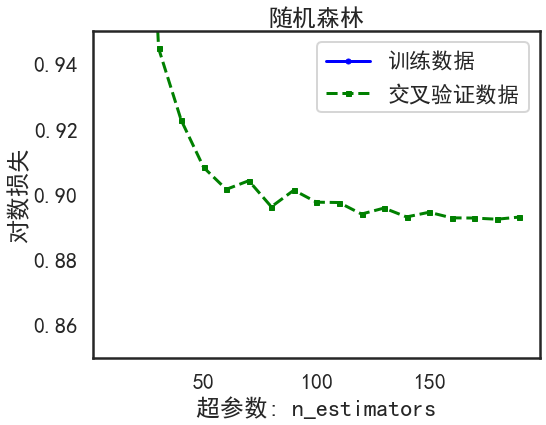

In [67]:
clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.xlabel('超参数: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.85, 0.95)

print('最优的{}为：{}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('对数损失值（训练数据）：  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('对数损失值(交叉验证数据)：{:.4f}'.format(-1*np.max(test_mean)))

In [68]:
best_clf = RandomForestClassifier(max_features=13, n_estimators=180)

np.random.seed(42)
best_clf.fit(Xtrain, ytrain)
ytest_prob = best_clf.predict_proba(Xtest)

#### 模型评估
print('随机森林模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

随机森林模型评估
对数损失：  0.8767
预测准确率：60.2%


特征重要性分析

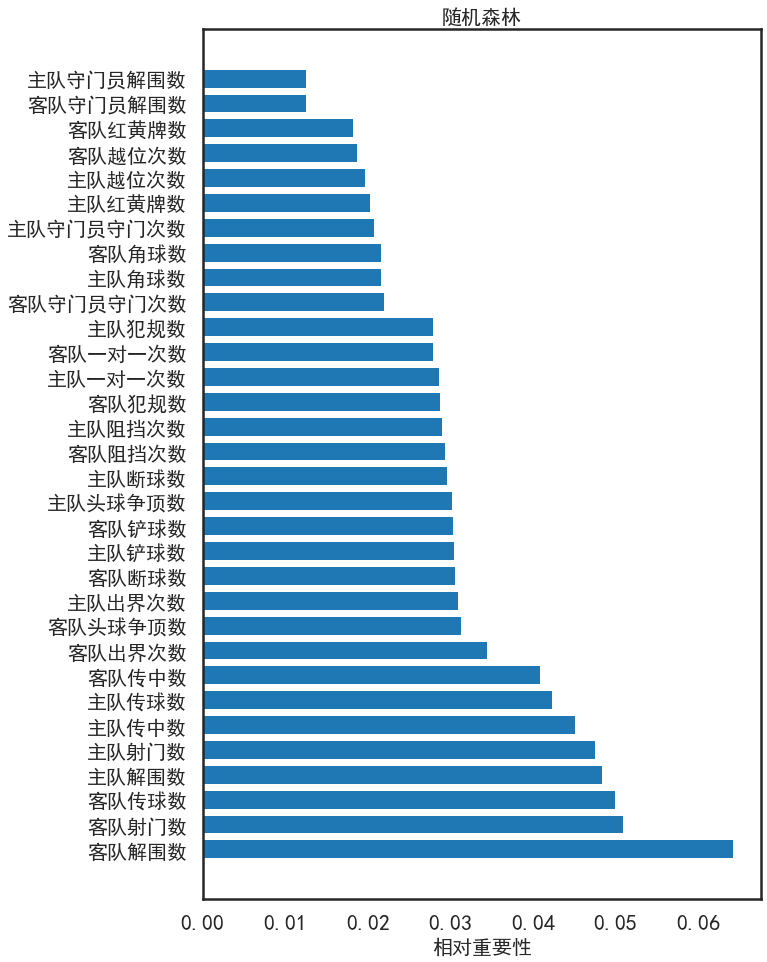

In [71]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,16))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('随机森林', fontsize=20)
plt.show()

随机森林模型中相对重要的特征有：解围数、射门数、传球数和传中数。

3.6 神经网络

In [72]:
# 训练集/验证集划分
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

In [85]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.7),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=200,
                    validation_data=(val_x, val_y), verbose=0)

当前模型训练集的准确率为58.62%
当前模型训练集的对数损失为0.881
当前模型验证集的准确率58.70%
当前模型验证集的对数损失为0.889


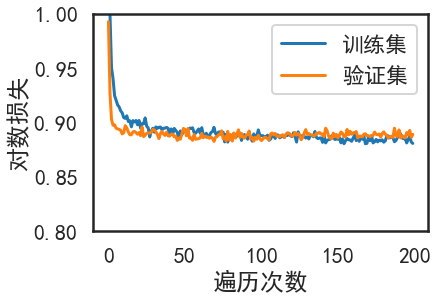

In [86]:
print('当前模型训练集的准确率为{:.2f}%'.format(history.history['acc'][-1]*100))
print('当前模型训练集的对数损失为{:.3f}'.format(history.history['loss'][-1]))

print('当前模型验证集的准确率{:.2f}%'.format(history.history['val_acc'][-1]*100))
print('当前模型验证集的对数损失为{:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.8, 1);

In [87]:
# 拟合训练数据
model.fit(Xtrain_norm, ytrain, epochs=200, verbose=0)

# 输出比赛结果概率估计
ytest_prob = model.predict_proba(Xtest_norm)

#### 模型评估
print('神经网络模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

神经网络模型评估
对数损失：  0.8548
预测准确率：60.2%


#### 参考资料

[1] Shmueli, Galit. To Explain or to Predict?. Statist. Sci. 25 (2010), no. 3, 289--310. doi:10.1214/10-STS330. https://projecteuclid.org/euclid.ss/1294167961

[2] Christian Collet (2013) The possession game? A comparative analysis of ball retention and team success in European and international football, 2007–2010, Journal of Sports Sciences, 31:2, 123-136, DOI: 10.1080/02640414.2012.727455

[3] Kerr, Matthew. (2015). Applying machine learning to event data in soccer.

[4] Kaggle European Soccer Database

[5] Squawka数据网站